In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib as plt
%matplotlib inline
import numpy as np

 Дан датасет, содержащий информацию об объявлениях на Airbnb в Лондоне

In [2]:
# подключение к базе default
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [9]:
q1 = '''
    SELECT 
        count(*)
    FROM 
        ldn_listings
   '''

# отправляем запрос и записываем результат в пандасовский датафрейм
test = ph.read_clickhouse(query=q1, connection=connection_default)
test.head()

,count()
0,85207


В базе 85207 строк. Выгрузим из таблицы данные о цене в зависимости от типа жилья.   
Необходимые столбцы:  
price – цена за ночь   
room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)    
review_scores_rating -отфильтровать пустые значения и сконвертировать эту колонку в тип float32.

In [10]:
# паттерн [$,] чтобы избавиться от $ и запятых
q2 = '''
    SELECT 
        id,
        room_type,
        toFloat32OrNull(replaceRegexpAll(review_scores_rating, '[$,]', '')) AS review_scores_rating,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price 
    FROM 
        ldn_listings
    WHERE NOT review_scores_rating IS NULL
    ORDER BY id
    LIMIT 1000
   '''


q_test = ph.read_clickhouse(query=q2, connection=connection_default)
q_test.head()

,id,room_type,review_scores_rating,price
0,13913,Private room,97.0,65.0
1,15400,Entire home/apt,96.0,100.0
2,17402,Entire home/apt,94.0,300.0
3,25023,Entire home/apt,93.0,65.0
4,25123,Private room,96.0,29.0


Сгруппируем полученный датафрейм по типу жилья и посчитаем 75-й перцентиль цены

In [12]:
q_test.groupby(['room_type'], as_index=False).price.quantile(q=0.75)

,room_type,price
0,Entire home/apt,152.0
1,Hotel room,157.0
2,Private room,60.0
3,Shared room,21.5


Построим график рассеивания, который покажет зависимость средней оценки от средней цены по типу жилья.

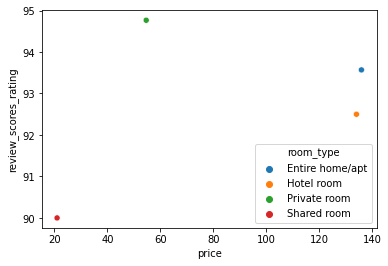

In [13]:
df=q_test.groupby(['room_type'], as_index=False).agg({'review_scores_rating': 'mean', 'price': 'mean'})
sns.scatterplot(x='price', y='review_scores_rating', data=df, hue='room_type')

#### Помимо аренды жилья, на Airbnb также есть "Впечатления" — мероприятия, которые организуют местные жители.
Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления
(experiences_offered != 'none').

In [14]:
query = '''
    SELECT 
        DISTINCT host_id,
        host_verifications
    FROM 
        ldn_listings
    WHERE experiences_offered!='none'
  '''
q_df = ph.read_clickhouse(query=query, connection=connection_default)

In [15]:
q_df.host_verifications \
                    .apply(lambda sp: sp.strip('[]').replace("'", "").split(', ')) \
                    .explode('host_verifications') \
                    .value_counts()

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

#### Посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления.
Новый столбец назовать experiences_count.

In [16]:
query_step_6 = '''
SELECT 
        neighbourhood_cleansed,
        experiences_offered,
        COUNT(host_id) AS experiences_count
        
    FROM 
        ldn_listings
    WHERE experiences_offered!='none'
    GROUP BY neighbourhood_cleansed, experiences_offered
    ORDER BY experiences_count DESC
    LIMIT 100
  '''
df_step_6 = ph.read_clickhouse(query=query_step_6, connection=connection_default)

#### Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления

In [17]:
z=df_step_6.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')

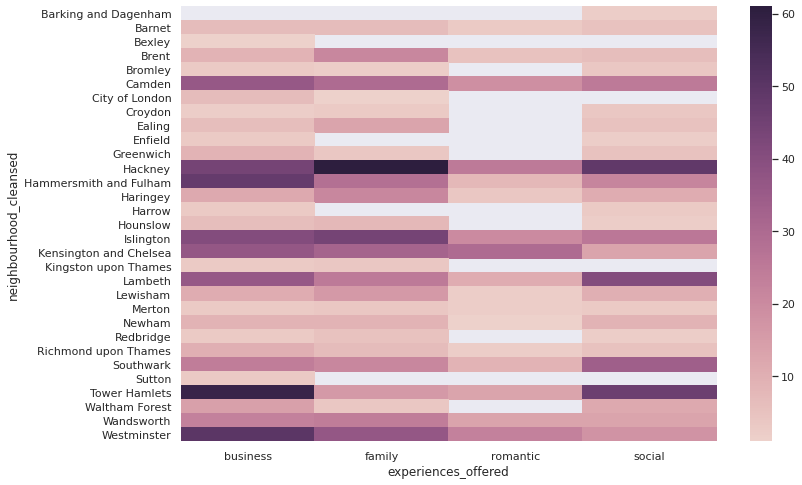

In [18]:
sns.set(rc = {'figure.figsize':(12,8)})
sns.heatmap(z, cmap=sns.cubehelix_palette(as_cmap=True))

#### Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. 

In [19]:
query_step_7 = '''
SELECT 
        room_type,
        toFloat32OrNull( replaceRegexpAll(price, '[$,]', '')) AS price
FROM 
        ldn_listings
WHERE experiences_offered!='none'
  '''
df_step_7 = ph.read_clickhouse(query=query_step_7, connection=connection_default)
df_step_7.head(3)

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0


#### Далее постройте два графика, используя distplot из библиотеки seaborn:
На первом отобразите исходные распределения цен для каждого типа жилья   
На втором – логарифмированные значения (np.log())   

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


TypeError: 'module' object is not callable

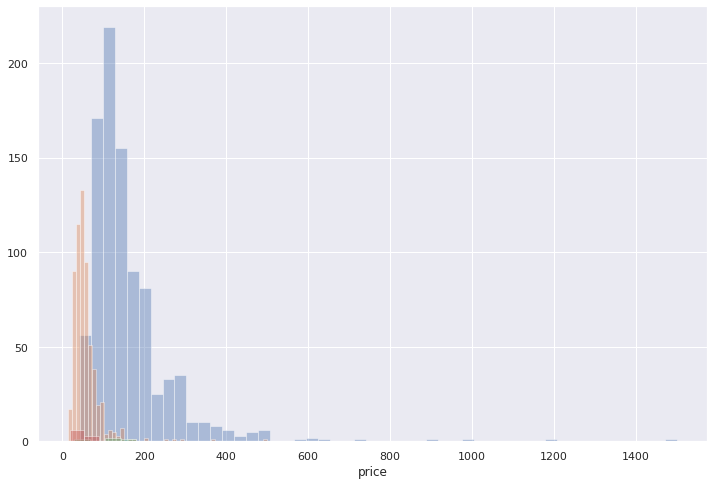

In [20]:
sns.set(rc = {'figure.figsize':(12,8)})
sns.distplot(df_step_7.query("room_type=='Entire home/apt'").price, kde=False, label='Entire home/apt')
sns.distplot(df_step_7.query("room_type=='Private room'").price, kde=False, label='Private room')
sns.distplot(df_step_7.query("room_type=='Hotel room'").price, kde=False, label='Hotel room')
sns.distplot(df_step_7.query("room_type=='Shared room'").price, kde=False, label='Shared room')
plt.legend()
plt.show()

TypeError: 'module' object is not callable

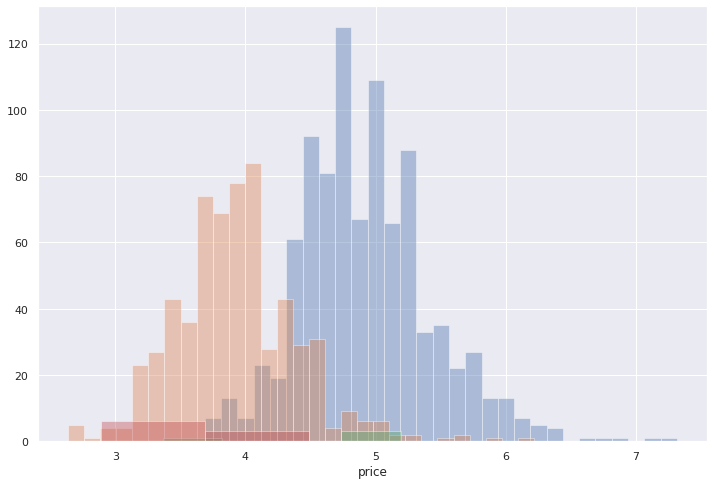

In [21]:
sns.distplot(np.log(df_step_7.query("room_type=='Entire home/apt'").price), kde=False, label='Entire home/apt')
sns.distplot(np.log(df_step_7.query("room_type=='Private room'").price), kde=False, label='Private room')
sns.distplot(np.log(df_step_7.query("room_type=='Hotel room'").price), kde=False, label='Hotel room')
sns.distplot(np.log(df_step_7.query("room_type=='Shared room'").price), kde=False, label='Shared room')
plt.legend()
plt.show()

#### Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года.

In [23]:
query_step_8 = '''
SELECT 
        room_type,
        toFloat32OrNull( replaceRegexpAll(price, '[$,]', '')) AS price,
        first_review
        
    FROM 
        ldn_listings
    WHERE first_review>'2010-01-01'
    LIMIT 1000
  '''
df_step_8 = ph.read_clickhouse(query=query_step_8, connection=connection_default)
df_step_8.head(3)

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05


#### постройте график динамики средних цен на жилье (ось Y) в зависимости от типа комнаты по годам (ось X).

In [24]:
df_step_8['years']=df_step_8.first_review.apply(lambda x: x[:-6])
df_step_8=df_step_8.sort_values('years')
df_step_8

,room_type,price,first_review,years
0,Private room,65.0,2010-08-18,2010
44,Private room,55.0,2010-12-31,2010
39,Private room,75.0,2010-12-20,2010
38,Entire home/apt,78.0,2010-10-26,2010
33,Private room,45.0,2010-10-06,2010
...,...,...,...,...
887,Private room,21.0,2019-05-01,2019
277,Private room,105.0,2019-05-23,2019
431,Private room,35.0,2019-03-23,2019
12,Private room,39.0,2020-02-08,2020


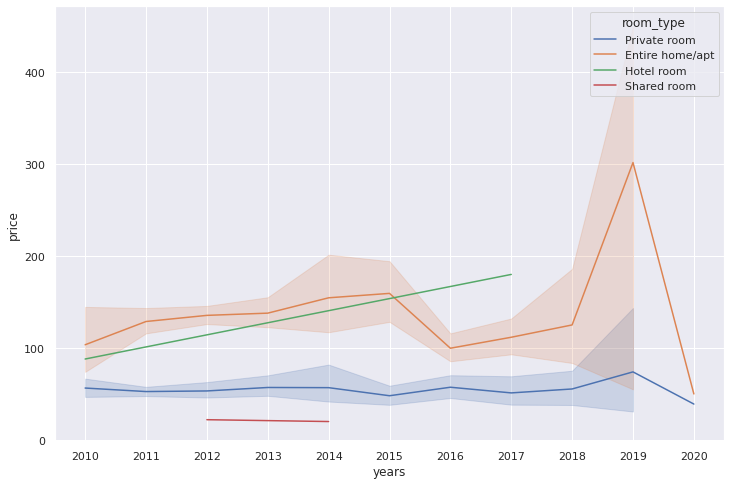

In [25]:
sns.lineplot(x='years', y='price', hue='room_type', data=df_step_8)